<h2>Transfer Learning with Convolutional Neural Networks For Classification with PyTorch </h2> 
<h4>Project: Stop Sign Classification</h4>

## Objectives

-   Import Libraries and Define Auxiliary Functions
-   Create Dataset Object
-   Load Model and Train

## Import Libraries and Define Auxiliary Functions

Libraries for Data Processing and Visualization

In [26]:
import copy
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time 
from matplotlib.pyplot import imshow
import random

Deep Learning Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader,random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
torch.manual_seed(0)

Defines a function plot_stuff to visualize the training progress, showing the total loss and accuracy over iterations.

In [3]:
def plot_stuff(cost, accuracy):    
    fig, ax1 = plt.subplots()
    color = 'red'
    ax1.plot(cost, color=color)
    ax1.set_xlabel('Iteration', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'blue'
    ax2.set_ylabel('accuracy', color=color)  
    ax2.plot(accuracy, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()
    
    plt.show()

Defines a function imshow_ to display images with their corresponding titles.

In [4]:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

Defines a function result to evaluate and display the model's prediction compared to the actual label.

In [5]:
def result(model,x,y):
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)

Define our device as the first visible cuda device if we have CUDA available:

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device type is", device)

The device type is cpu


## Load Data

In [7]:
# Define transforms to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])
percentage_train=0.9
dataset_folder = "./dataset"
dataset = ImageFolder(root=dataset_folder, transform=transform)
total_size = len(dataset)
train_size = int(percentage_train * total_size)
val_size = total_size - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
# Create data loaders
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

We can plot some of our dataset:

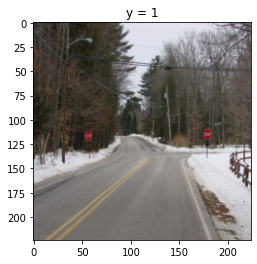

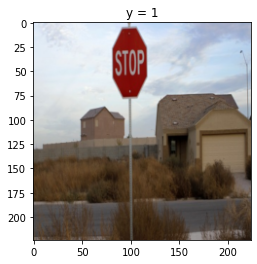

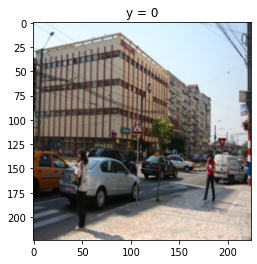

In [8]:
i = 0
for x, y in val_loader:
    # Assuming x has dimensions (batch_size, channels, height, width)
    # Adjust the permutation accordingly
    x = x.squeeze(0)  # Squeeze out the batch dimension if batch_size is 1
    plt.imshow(x.permute(1, 2, 0))  # Convert tensor to numpy array and rearrange dimensions for displaying images
    plt.title(f"y = {y.item()}")
    plt.show()
    i+=1
    if i==3:
        break

## Hyperparameters

In [9]:
n_epochs=10
batch_size=32
lr=0.000001
momentum=0.9
lr_scheduler=True
base_lr=0.001
max_lr=0.01

# Load Model and Train

This function will train the model :

In [10]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            model.train() 

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        scheduler.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

Load the pre-trained model resnet18. Set the parameter pretrained to true.

In [12]:
model = models.resnet18(pretrained=True)

We will only train the last layer of the network set the parameter <code>requires_grad</code> to <code>False</code>, the network is a fixed feature extractor.


In [13]:
for param in model.parameters():
    param.requires_grad = False

Number of classes

In [14]:
n_classes = len(dataset.classes)
print("Number of classes:", n_classes)

Number of classes: 2


Replace the output layer model.fc of the neural network with a nn.Linear object, to classify <code>n_classes</code> different classes.The last hidden layer has 512 neurons.

In [15]:
model.fc = nn.Linear(512, n_classes)

Set device type

In [16]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Defines the loss function (cross-entropy) and optimizer (SGD) for training the model.

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

We use Cyclical Learning Rates

In [18]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,step_size_up=5,mode="triangular2")

Train model

In [19]:
start_datetime = datetime.now()
start_time=time.time() 

accuracy_list,loss_list, model=train_model(model,train_loader , val_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

epoch 0 done


 10%|████████▎                                                                          | 1/10 [00:09<01:21,  9.05s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 1.4278784598096268
The validation accuracy for epoch 1: 0.55
epoch 1 done


 20%|████████████████▌                                                                  | 2/10 [00:18<01:12,  9.07s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 2.718359381304043
The validation accuracy for epoch 2: 0.5
epoch 2 done


 30%|████████████████████████▉                                                          | 3/10 [00:27<01:03,  9.07s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 2.6352276570227904
The validation accuracy for epoch 3: 0.85
epoch 3 done


 40%|█████████████████████████████████▏                                                 | 4/10 [00:36<00:54,  9.08s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 3.4219049129840355
The validation accuracy for epoch 4: 0.9
epoch 4 done


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:45<00:45,  9.07s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 4.2419688476116635
The validation accuracy for epoch 5: 0.65
epoch 5 done


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:54<00:36,  9.06s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 4.3341966288489715
The validation accuracy for epoch 6: 0.7
epoch 6 done


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:03<00:27,  9.14s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 3.31709416405587
The validation accuracy for epoch 7: 0.8
epoch 7 done


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:13<00:18,  9.38s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 2.6148722342780193
The validation accuracy for epoch 8: 0.8
epoch 8 done


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:23<00:09,  9.62s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 1.8085545768060263
The validation accuracy for epoch 9: 0.8
epoch 9 done


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.36s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 1.1224233000670787
The validation accuracy for epoch 10: 0.9
elapsed time 93.66179060935974


Save the model to model.pt

In [20]:
torch.save(model.state_dict(), 'model.pt')

Plot train cost and validation accuracy, you can improve results by getting more data.

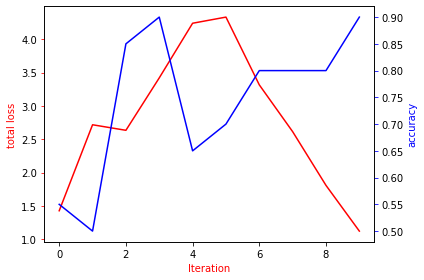

In [21]:
plot_stuff(loss_list,accuracy_list)

In [22]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

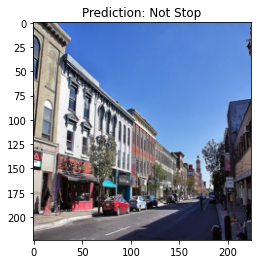

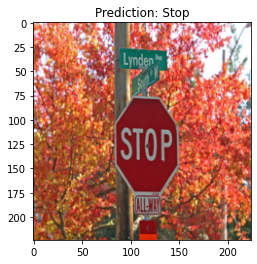

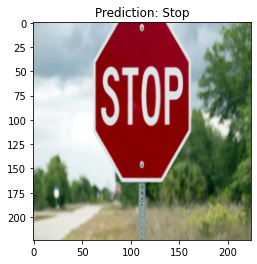

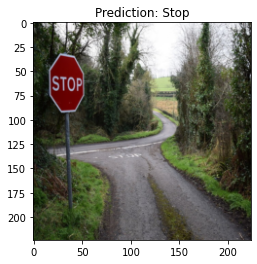

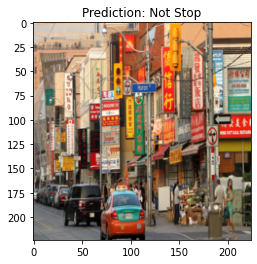

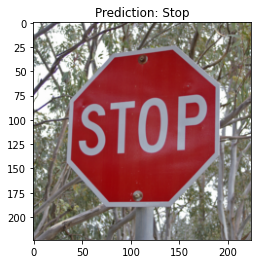

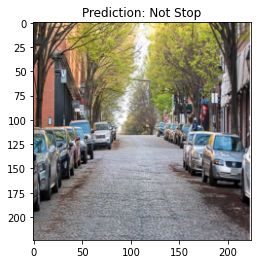

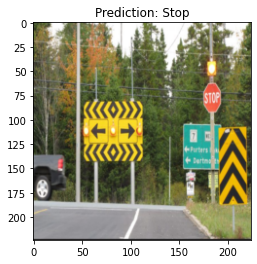

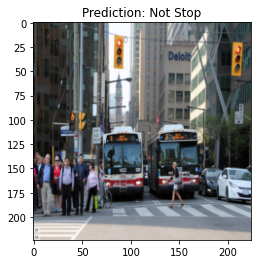

In [27]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),           
])
test_folder = "./test"
test_dataset = ImageFolder(root=test_folder, transform=transform)
random.shuffle(test_dataset.imgs)
class_labels = test_dataset.classes
for image_path, label in test_dataset.imgs:
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)
    z=model(image_tensor)
    _,yhat=torch.max(z.data, 1)
    prediction = "Not Stop"
    if yhat == 1:
        prediction ="Stop"
    imshow_(transform(image),f"Prediction: {prediction}")